# SpikeUNet

## *01 - data setup.ipynb*

Initial data setup, where we create the dataframes for the training of the model.


### Imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
import pandas as pd
import random
from collections.abc import Generator

### Load input data

We start by loading the input data, and ensuring the correct folder structure.

In [2]:
full_traces_folder = "full_traces"
split_traces_folder = "split_traces"
full_labels_folder = "full_labels"
split_labels_folder = "split_labels"

# If the split traces folder doesn't exist, create it
if not os.path.exists(split_traces_folder):
    os.makedirs(split_traces_folder)

# If the labels folder doesn't exist, create it
if not os.path.exists(full_labels_folder):
    os.makedirs(full_labels_folder)

# If the split labels folder doesn't exist, create it
if not os.path.exists(split_labels_folder):
    os.makedirs(split_labels_folder)

# Check we hava a train and a validation subfolder
if not os.path.exists(os.path.join(split_traces_folder, 'train')):
    os.makedirs(os.path.join(split_traces_folder, 'train'))
if not os.path.exists(os.path.join(split_traces_folder, 'val')):
    os.makedirs(os.path.join(split_traces_folder, 'val'))

if not os.path.exists(os.path.join(split_labels_folder, 'train')):
    os.makedirs(os.path.join(split_labels_folder, 'train'))
if not os.path.exists(os.path.join(split_labels_folder, 'val')):
    os.makedirs(os.path.join(split_labels_folder, 'val'))
    
# Find all txt files
traces_filenames = [f for f in os.listdir(full_traces_folder) if f.endswith('.txt')]
# Order them by name
traces_filenames = sorted(traces_filenames)

raw_traces = []

for f in traces_filenames:
    # Read the data
    print(f"Reading {f}...")
    trace = pd.read_csv(os.path.join(full_traces_folder, f), sep=' ')
    trace.columns = ['Time', 'Voltage']
    trace.reset_index(drop=True, inplace=True)
    raw_traces.append(trace)

Reading 1.txt...
Reading 2.txt...
Reading 3.txt...
Reading 4.txt...


In [3]:
def plot_trace(trace:pd.DataFrame, labels:np.ndarray, seconds_from:int = -1, seconds_to:int = -1) -> None:
    '''
    Plot a single trace file.

    Parameters:
        trace (pd.DataFrame): The trace to plot
        labels (np.array): The labels for the trace
        seconds_from (int): The start time to plot in seconds
        seconds_to (int): The end time to plot in seconds
    ''' 

    # Plot the data
    # Black = background (0), Orange = spikes (1), Purple = bursts (2)
    cmap = ['black', 'orange', 'purple']
    # Concatenate points into a 1 x 2 array (time, voltage)
    points = np.array([trace['Time']/1000, trace['Voltage']]).T.reshape(-1, 1, 2)
    # Concatenate the points two by two to get the segments
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, colors = [cmap[l] for l in labels], linewidth=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.add_collection(lc)
    if seconds_from != -1 and seconds_to != -1:
        ax.set_xlim(seconds_from, seconds_to)
    else:
        ax.set_xlim(trace['Time'].min()/1000, trace['Time'].max()/1000)

    # Add some padding to the y axis        
    yrange = trace['Voltage'].max() - trace['Voltage'].min()
    ymin = trace['Voltage'].min() - yrange / 20
    ymax = trace['Voltage'].max() + yrange / 20
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (mV)')

    plt.show()

### Label training and validation data

We now manually label the training and validation data. 

We use the following labels:

* 0: Background
* 1: Spike
* 2: Burst

This can be improved in the future, but let's see if we can get a working model first.

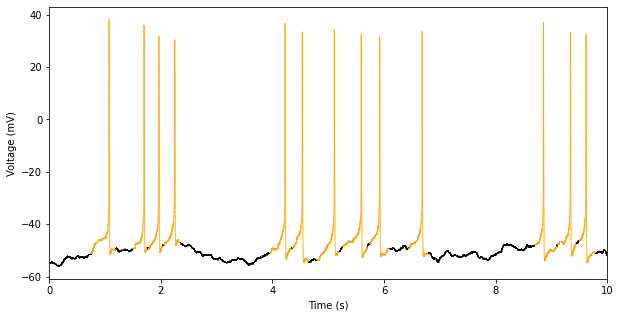

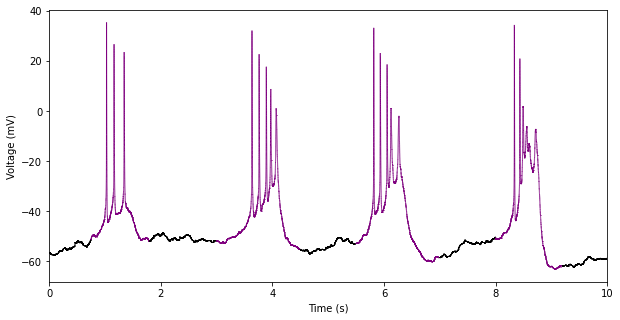

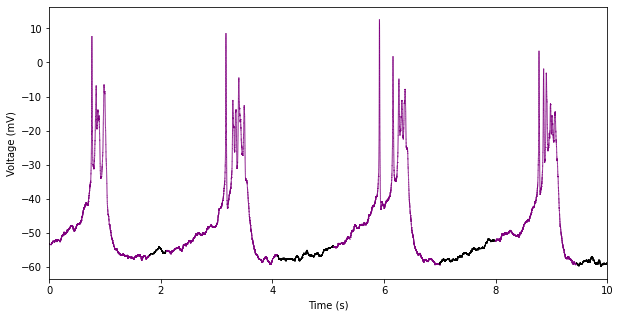

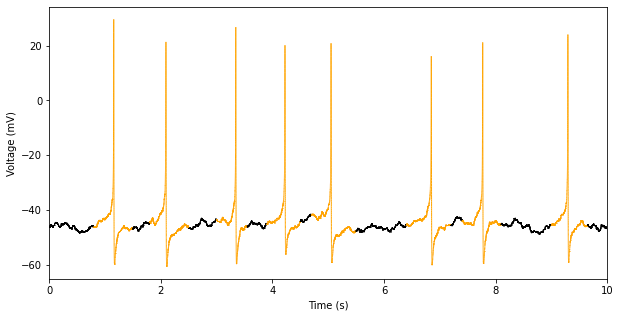

In [4]:
def generate_labels(trace_length:int, start_end:pd.DataFrame) -> np.ndarray:
    '''
    Generate labels for a trace.

    Parameters:
        trace_length (int): The length of the trace
        start_end (pd.DataFrame): The start and end times for the spikes and bursts
    
    Returns:
        np.array: The labels for the trace, where 0 = background, 1 = spike, 2 = burst
    '''

    # Initialize the labels to 0
    labels = np.zeros(trace_length).astype(np.uint8)

    # Add the spikes
    spikes_start = start_end[start_end['Type'] == 'Spike Start']['Time'].values
    spikes_end = start_end[start_end['Type'] == 'Spike End']['Time'].values
    if spikes_start is not None and spikes_end is not None:
        for i in range(len(spikes_start)):
            labels[spikes_start[i]:spikes_end[i]] = 1
    
    # Add the bursts
    bursts_start = start_end[start_end['Type'] == 'Burst Start']['Time'].values
    bursts_end = start_end[start_end['Type'] == 'Burst End']['Time'].values
    if bursts_start is not None and bursts_end is not None:
        for i in range(len(bursts_start)):
            labels[bursts_start[i]:bursts_end[i]] = 2
    
    return labels


def create_start_end_dataframe(spikes_start:np.ndarray = np.array([]), spikes_end:np.ndarray = np.array([]),
    bursts_start:np.ndarray = np.array([]), bursts_end:np.ndarray = np.array([])) -> pd.DataFrame:
    '''
    Create a Pandas dataframe containing the start and end times of spikes and bursts.
    
    Parameters:
        spikes_start (np.ndarray): The start times of the spikes. Default is an empty array.
        spikes_end (np.ndarray): The end times of the spikes. Default is an empty array.
        bursts_start (np.ndarray): The start times of the bursts. Default is an empty array.
        bursts_end (np.ndarray): The end times of the bursts. Default is an empty array.
    
    Returns:
        pd.DataFrame: A dataframe containing the start and end times of spikes and bursts
    '''

    times = []
    types = []

    if len(spikes_start) != 0 and len(spikes_end) != 0:
        for i in range(len(spikes_start)):
            times.append(spikes_start[i])
            types.append('Spike Start')
            times.append(spikes_end[i])
            types.append('Spike End')

    if len(bursts_start) != 0 and len(bursts_end) != 0:
        for i in range(len(bursts_start)):
            times.append(bursts_start[i])
            types.append('Burst Start')
            times.append(bursts_end[i])
            types.append('Burst End')


    start_end = pd.DataFrame({'Time': times, 'Type': types})

    return start_end.sort_values(by=['Time'])


full_labels = []

# Trace 0

spikes_start = np.array([7500, 15000, 17800, 20500, 39500, 43600, 48000, 52500, 57500, 64500, 87000, 91100, 95000])
spikes_end = np.array([12000, 17600, 20400, 23500, 43500, 46500, 52000, 57000, 61000, 68000, 91000, 94500, 98000])
burst_start = np.array([])
burst_end = np.array([])

start_end = create_start_end_dataframe(spikes_start, spikes_end, burst_start, burst_end)
labels = generate_labels(raw_traces[0].shape[0], start_end)
full_labels.append(labels)
plot_trace(raw_traces[0], labels)

# Save spike/burst start/end to file
start_end.to_csv(f'{full_labels_folder}/0.csv', index=False)

# Trace 1

spikes_start = np.array([])
spikes_end = np.array([])
burst_start = np.array([7500, 30000, 55000, 80000])
burst_end = np.array([18000, 45000, 70000, 92000])

start_end = create_start_end_dataframe(spikes_start, spikes_end, burst_start, burst_end)
labels = generate_labels(raw_traces[1].shape[0], start_end)
full_labels.append(labels)
plot_trace(raw_traces[1], labels)

# Save spike/burst start/end to file
start_end.to_csv(f'{full_labels_folder}/1.csv', index=False)

# Trace 2

spikes_start = np.array([])
spikes_end = np.array([])
burst_start = np.array([0, 21000, 51000, 80000])
burst_end = np.array([18000, 41000, 70000, 94500])

start_end = create_start_end_dataframe(spikes_start, spikes_end, burst_start, burst_end)
labels = generate_labels(raw_traces[2].shape[0], start_end)
full_labels.append(labels)
plot_trace(raw_traces[2], labels)

# Save spike/burst start/end to file
start_end.to_csv(f'{full_labels_folder}/2.csv', index=False)

# Trace 3

spikes_start = np.array([8000, 18000, 30000, 39000, 47000, 64000, 74000, 90000])
spikes_end = np.array([15000, 25000, 35500, 45000, 55000, 72000, 81000, 96500])
burst_start = np.array([])
burst_end = np.array([])

start_end = create_start_end_dataframe(spikes_start, spikes_end)
labels = generate_labels(raw_traces[3].shape[0], start_end)
full_labels.append(labels)
plot_trace(raw_traces[3], labels)

# Save spike/burst start/end to file
start_end.to_csv(f'{full_labels_folder}/3.csv', index=False)

### Split the data

In [6]:
def process_trace(trace:pd.DataFrame, labels:np.ndarray, n_points:int, offset:int = -1) -> Generator:
    '''
    Process a single trace file into blocks of defined length. Save the blocks for later use.

    Parameters:
        num_trace (pd.DataFrame): The number of the trace to process. Shape n_points x 2 (time, voltage)
        labels (np.ndarray): The labels for the trace. Shape n_points x 1 (0 = no event, 1 = spike, 2 = burst)
        n_points (int): The number of points to split the trace into
        offset (int): The offset for the sliding window. Default is -1, which means that the window will slide by n_points points.

    Returns:
        A generator that yields the processed blocks of the trace
    '''

    assert(trace.shape[0] == len(labels))

    # Make sure the data is divisible by n_points with an offset of offset. 
    # This might remove the last few points, but it's not a big deal for this,
    # since we're only using these traces for training. At evaluation time, we can either pad the traces to the correct 
    # length or use overlapping blocks.
    if offset == -1:
        offset = n_points
    
    extra_points = (trace.shape[0] - n_points) % offset
    if extra_points > 0:
        trace = trace.iloc[:trace.shape[0] - extra_points]
        labels = labels[:labels.shape[0] - extra_points]

    # Drop the time column
    trace = trace.drop('Time', axis=1)

    # Split the data into blocks. Note that we use split rather than array_split, since the latter does not guarantee that
    # the blocks will be the same size (which should be anyway because of the line above!)
    for i in range(0, trace.shape[0] - n_points, offset):
        block = trace.iloc[i:i+n_points]
        block_labels = labels[i:i+n_points]
        yield np.concatenate((block, block_labels.reshape(-1, 1)), axis=1)    

Save to file with a 80/20 split for training/validation set

In [7]:
# Empty the training and validation folders
for folder in [split_traces_folder, split_labels_folder]:
    for split in ['train', 'val']:
        for f in os.listdir(f'{folder}/{split}'):
            os.remove(f'{folder}/{split}/{f}')

counter = 0

# Set the random seed, for reproducibility
random.seed(12345)

for tr, lab in zip(raw_traces, full_labels):
    blocks = process_trace(tr, lab, n_points=1000, offset=100)

    # Save to file, with a 80/20 split for training and validation
    for b in blocks:
        if np.random.rand() <= 0.8:
            np.savetxt(f'{split_traces_folder}/train/{counter}.txt', b[:, 0], fmt="%0.3f")
            np.savetxt(f'{split_labels_folder}/train/{counter}.txt', b[:, 1], fmt="%d")
        else:
            np.savetxt(f'{split_traces_folder}/val/{counter}.txt', b[:, 0], fmt="%0.3f")
            np.savetxt(f'{split_labels_folder}/val/{counter}.txt', b[:, 1], fmt="%d")
    
        counter += 1

# Count the number of training and validation files and get %
train_files = len(os.listdir(f'{split_traces_folder}/train'))
val_files = len(os.listdir(f'{split_traces_folder}/val'))

print(f'Training files: {train_files} ({train_files / (train_files + val_files) * 100:.2f}%)')
print(f'Validation files: {val_files} ({val_files / (train_files + val_files) * 100:.2f}%)')

Training files: 3186 (80.45%)
Validation files: 774 (19.55%)
